In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import numba

In [2]:
#N = 384, 256
N = 96, 64
#N = 15, 10
L = 15.0, 10.0
u = np.zeros(N)

In [3]:
# Arrays for setting the initial conditions
x = np.linspace(-0.5*L[0], 0.5*L[0], N[0])
y = np.linspace(-0.5*L[1], 0.5*L[1], N[1])
xv, yv = np.meshgrid(x, y, sparse=False, indexing='ij')

We'll define the type of boundary points as faces or edges using this labeling:
$$
\begin{pmatrix}
0 & 1 & 2 \\
3 &   & 4 \\
5 & 6 & 7 \\
\end{pmatrix}
$$
For example, a boundary point with type 7 is a lower right corner, 
with fluid flow on the bottom and left.

In [4]:
TOP, BOTTOM, LEFT, RIGHT = 1, 6, 3, 4
TOPL, TOPR, BOTL, BOTR = 0, 2, 5, 7

In [5]:
# Make shape for boundary: a rectangle from (40,24) to (56,40), inclusive
top, bottom, left, right = 40, 24, 40, 56 
bpoints = []
btype = []
for i in range(left+1, right):
    bpoints.append((i, top)); btype.append(TOP)
    bpoints.append((i, bottom)); btype.append(BOTTOM)
for j in range(bottom+1, top):
    bpoints.append((left, j)); btype.append(LEFT)
    bpoints.append((right, j)); btype.append(RIGHT)
bpoints.append((left, top)); btype.append(TOPL)
bpoints.append((right, top)); btype.append(TOPR)
bpoints.append((left, bottom)); btype.append(BOTL)
bpoints.append((right, bottom)); btype.append(BOTR)
bpoints = np.array(bpoints)
btype = np.array(btype)
mask = np.ones(N, dtype=np.uint8)
for i,j in bpoints:
    mask[i,j] = 0
#mask[left:right+1, bottom:top+1] = 0

In [6]:
@numba.jit(nopython=True)
def smooth(u, mask):
    for i in range(1, N[0]-1):
        for j in range(1 + i % 2, N[1]-1, 2):
            u[i,j] = mask[i,j] * 0.25 * (u[i+1,j] + u[i,j+1] + u[i-1,j] + u[i,j-1]) \
                   + (1-mask[i,j]) * u[i,j]
    for i in range(1, N[0]-1):
        for j in range(2 - i % 2, N[1]-1, 2):
            u[i,j] = mask[i,j] * 0.25 * (u[i+1,j] + u[i,j+1] + u[i-1,j] + u[i,j-1]) \
                               + (1-mask[i,j]) * u[i,j]

In [7]:
@numba.jit(nopython=True)
def apply_bc(u):
    for icell in range(len(btype)):
        i, j = bpoints[icell]
        itype = btype[icell]
        if (itype == TOP):
            u[i,j] = u[i,j+2]
        elif (itype == BOTTOM):
            u[i,j] = u[i,j-2]
        elif (itype == LEFT):
            u[i,j] = u[i-2,j]
        elif (itype == RIGHT):
            u[i,j] = u[i+2,j]
        elif (itype == TOPL):
            u[i,j] = 0.5 * (u[i,j+2] + u[i-2,j])
        elif (itype == TOPR):
            u[i,j] = 0.5 * (u[i,j+2] + u[i+2,j])
        elif (itype == BOTL):
            u[i,j] = 0.5 * (u[i,j-2] + u[i-2,j])
        elif (itype == BOTR):
            u[i,j] = 0.5 * (u[i,j-2] + u[i+2,j])        

In [8]:
@numba.jit(nopython=True)
def force():
    fx, fy = np.zeros(N), np.zeros(N)
    for icell in range(len(btype)):
        i, j = bpoints[icell]
        itype = btype[icell]
        if (itype == TOP):
            fy[i,j] += v[i,j+1]**2
        elif (itype == BOTTOM):
            fy[i,j] -= v[i,j-1]**2
        elif (itype == LEFT):
            fx[i,j] -= v[i-1,j]**2
        elif (itype == RIGHT):
            fx[i,j] += v[i+1,j]**2
        elif (itype == TOPL):
            fx[i,j] -= v[i-1,j]**2
            fy[i,j] += v[i,j+1]**2
        elif (itype == TOPR):
            fx[i,j] += v[i+1,j]**2
            fy[i,j] += v[i,j+1]**2
        elif (itype == BOTL):
            fx[i,j] -= v[i-1,j]**2
            fy[i,j] -= v[i,j-1]**2
        elif (itype == BOTR):
            fx[i,j] += v[i+1,j]**2
            fy[i,j] -= v[i,j-1]**2
    return fx, fy

In [9]:
# Initial conditions (uniform flow to the right)
u[:,:] = -xv

In [10]:
apply_bc(u)
for i in range(1000):
    smooth(u, mask)
    apply_bc(u)

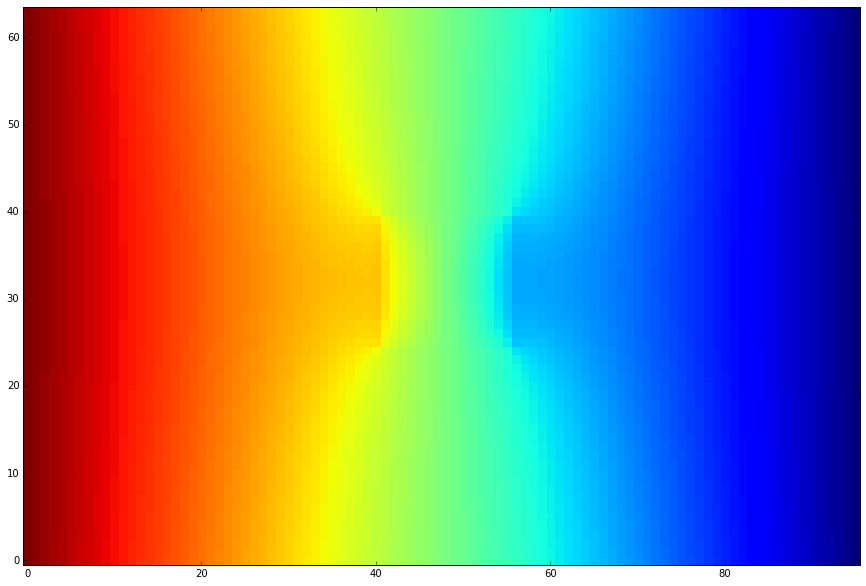

In [11]:
plt.imshow(u.transpose(), origin="lower", interpolation='nearest'); plt.gcf().set_size_inches(15,10)

In [12]:
dx, dy = np.gradient(u)
dx[left:right+1, bottom:top+1] = 0
dy[left:right+1, bottom:top+1] = 0
v = np.sqrt(dx**2 + dy**2)

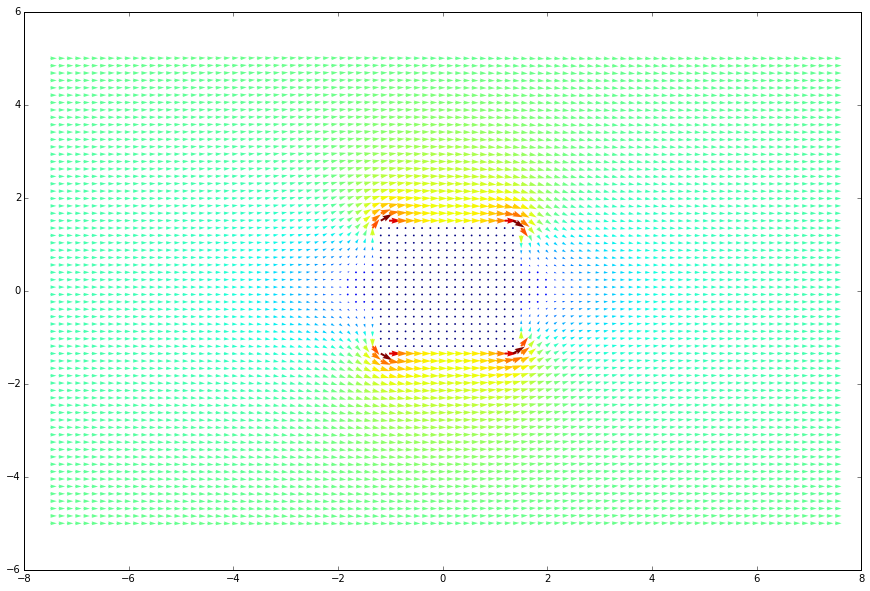

In [13]:
plt.quiver(xv, yv, -dx, -dy, v); plt.gcf().set_size_inches(15,10)

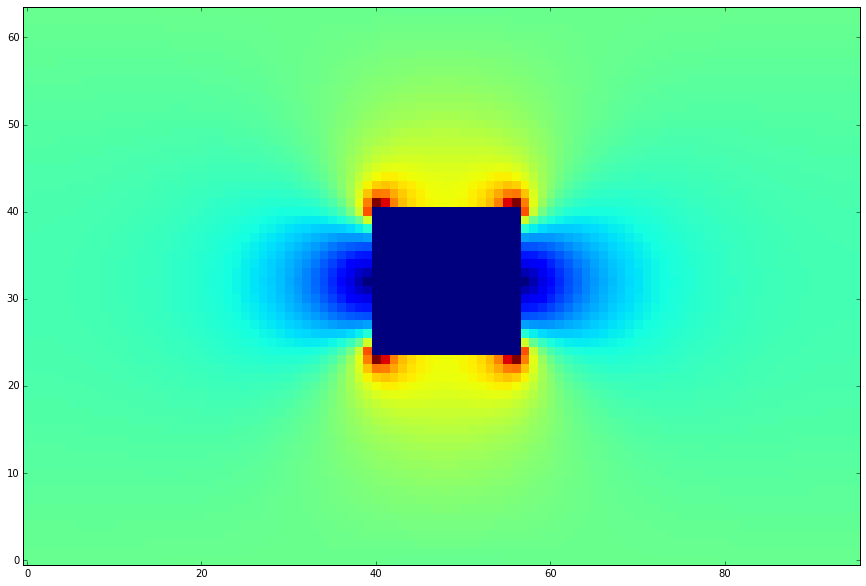

In [14]:
plt.imshow(v.transpose(), origin="lower", interpolation='nearest'); plt.gcf().set_size_inches(15,10)

In [15]:
fx, fy = force()

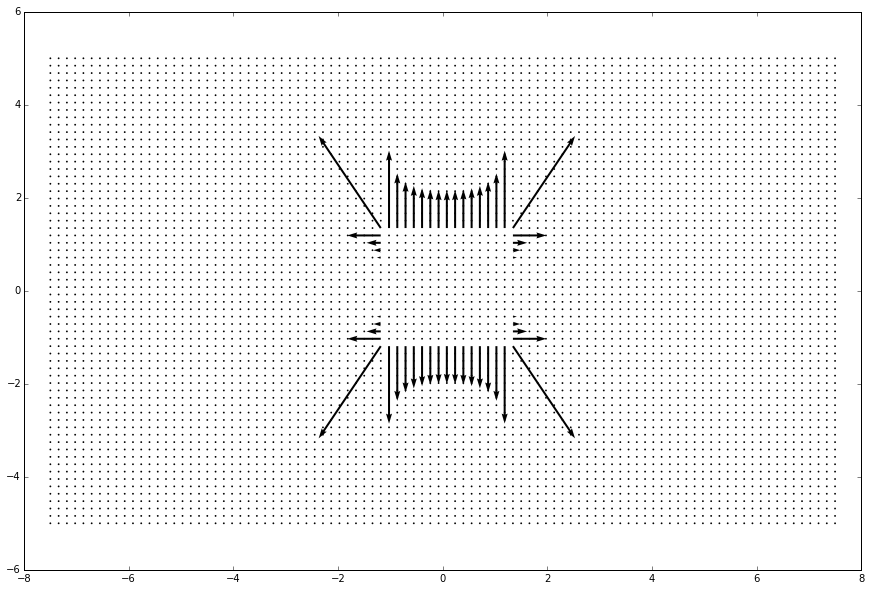

In [16]:
plt.quiver(xv, yv, fx, fy, scale=1.); plt.gcf().set_size_inches(15,10)

In [17]:
fx.sum(), fy.sum()

(-0.0002302428607986462, -0.0016065527657470255)